In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("..")
from Pipelines.DAP import DifferentiallyAbundantProteins as DAP

#Read datafile
proteomics_data = pd.read_csv("C:/Users/keimp/AAA_AMC/data/20250331 AAA plasma proteomics raw data.csv", delimiter=";")
#Rotate data into wide format
proteomics_data = proteomics_data.transpose()
#Convert the samples into a column
proteomics_data = proteomics_data.reset_index()
#Make the first row the column names
proteomics_data.columns = proteomics_data.iloc[0]
proteomics_data = proteomics_data[1:]
#rename sample column
proteomics_data = proteomics_data.rename(columns={'Genes': 'Sample_index'})
#Get the proteins
proteins = proteomics_data.columns.values.tolist()[1:]

meta_data = pd.read_csv("C:/Users/keimp/AAA_AMC/data/plasma_proteomics_meta_file_rawDataCSV.csv", delimiter=";")
df = pd.merge(proteomics_data, meta_data, on="Sample_index", how="inner")
df = df.loc[(df["Pathology"]=="AAA") | (df["Pathology"]=="Controle")]

for p in proteins:
    df[p] = df[p].astype(str).str.replace(',', '.')
    df[p] = pd.to_numeric(df[p], errors='coerce')

df = df.dropna(axis=1, how="all")
proteins.remove("FABP1")

df = df.reset_index(drop=True)

In [16]:
from scipy.stats import spearmanr
import networkx as nx
import seaborn as sns

In [17]:
d = DAP(df, "Sample_index", "SimplePathology", proteins)
d.missing_filtering(25, percentage=True)
tdf = d.get_data()[d.get_proteins()]

In [18]:
tdf = df[d.get_proteins()]

In [19]:
# Function to calculate pairwise correlations 
def calculate_correlation_matrix(expression_data):
    correlation_matrix = expression_data.corr(method="spearman")
    return correlation_matrix

In [20]:
combined_corr_matrix = calculate_correlation_matrix(tdf)
combined_corr_matrix.head()

EEF1G     PSMD5       RAN    LGALS1    CAPZA1    PPP1CB    NAP1L4  \
EEF1G   1.000000  0.884647  0.673721  0.647899  0.940916  0.859848  0.949218   
PSMD5   0.884647  1.000000  0.715228  0.603089  0.856048  0.783051  0.927732   
RAN     0.673721  0.715228  1.000000  0.511472  0.633814  0.553951  0.759262   
LGALS1  0.647899  0.603089  0.511472  1.000000  0.723895  0.711616  0.657910   
CAPZA1  0.940916  0.856048  0.633814  0.723895  1.000000  0.915374  0.913684   

          CAPZA2      CAP1     CALM1  ...     ACTN3     HYDIN   B4GALT5  \
EEF1G   0.907229  0.815284  0.899364  ... -0.136954  0.372763  0.243376   
PSMD5   0.824869  0.689552  0.831208  ... -0.325665  0.111101  0.159965   
RAN     0.535501  0.540144  0.775946  ...  0.130201  0.401051  0.290179   
LGALS1  0.662583  0.751297  0.713884  ...  0.019401  0.184525  0.042464   
CAPZA1  0.969130  0.916399  0.898628  ... -0.210528  0.338763  0.189228   

           PRSS3   C1QTNF5      CD63  IGHV4-30-2     IGKJ1     IGLL1  \
EEF1G  -0.265250 -0.165634  0.903982    0.071153  0.020680  0.191909   
PSMD5  -0.451707 -0.181765  0.783471    0.095017 -0.063604  0.196241   
RAN    -0.045178  0.137756  0.535404    0.074970  0.009901  0.077261   
LGALS1 -0.168760 -0.220397  0.663292    0.113337  0.010184  0.110643   
CAPZA1 -0.286190 -0.268966  0.930142    0.023820  0.018780  0.188154   

        IGKV6D-21  
EEF1G    0.101767  
PSMD5    0.116552  
RAN      0.096291  
LGALS1   0.072706  
CAPZA1   0.139789  

[5 rows x 1017 columns]

In [21]:
def create_network(corr_matrix, threshold=0.7):
    G = nx.Graph()
    for i, gene1 in enumerate(corr_matrix.index):
        for j, gene2 in enumerate(corr_matrix.columns):
            if i < j:  # Avoid duplicate pairs
                correlation = corr_matrix.iloc[i, j]
                if abs(correlation) >= threshold:  # Apply threshold
                    G.add_edge(gene1, gene2, weight=correlation)
    return G

# Define threshold for correlation
threshold = 0.75

# Create combined network for all samples and analyze the combined network 
combined_network = create_network(combined_corr_matrix, threshold)
print(f"Combined Network: {combined_network.number_of_nodes()} nodes and {combined_network.number_of_edges()} edges")

Combined Network: 752 nodes and 76949 edges


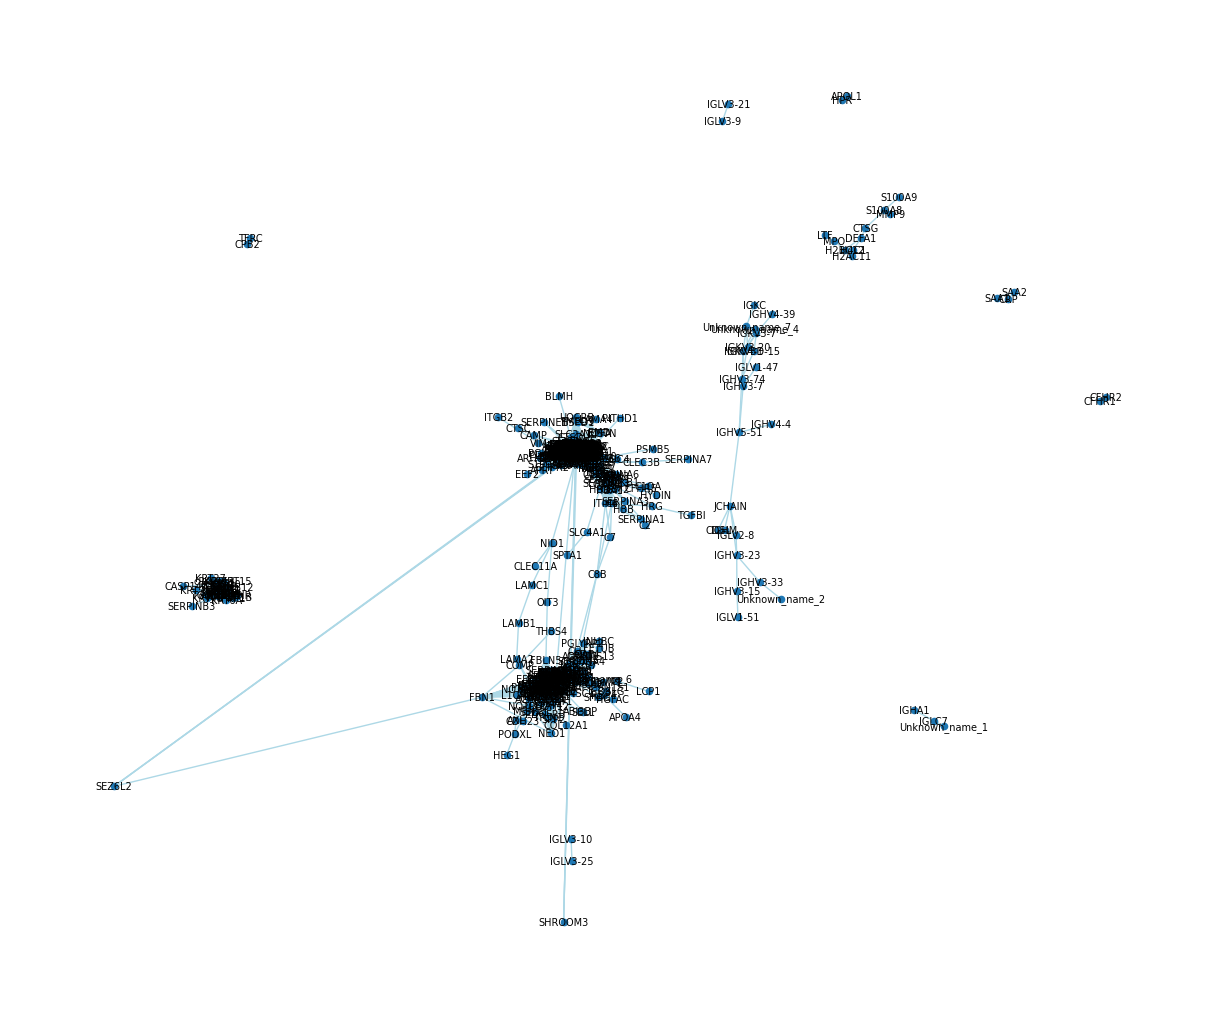

Top 10 hub genes:
[('GNAI2', 437), ('ACTN4', 428), ('CAPZA1', 427), ('GNB1', 427), ('CLIC1', 424), ('CAPZB', 423), ('TPM3', 422), ('LASP1', 422), ('CD47', 422), ('HSP90AA1', 420)]


In [22]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(combined_network, seed=42)
nx.draw(combined_network, pos, with_labels=False, node_size=20, edge_color="lightblue")
nx.draw_networkx_labels(combined_network, pos, labels={node: node for node in combined_network.nodes}, font_size=7)
plt.show()

# identify hub genes in network
degrees = dict(combined_network.degree())
sorted_genes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
print("Top 10 hub genes:")
print(sorted_genes[:10])

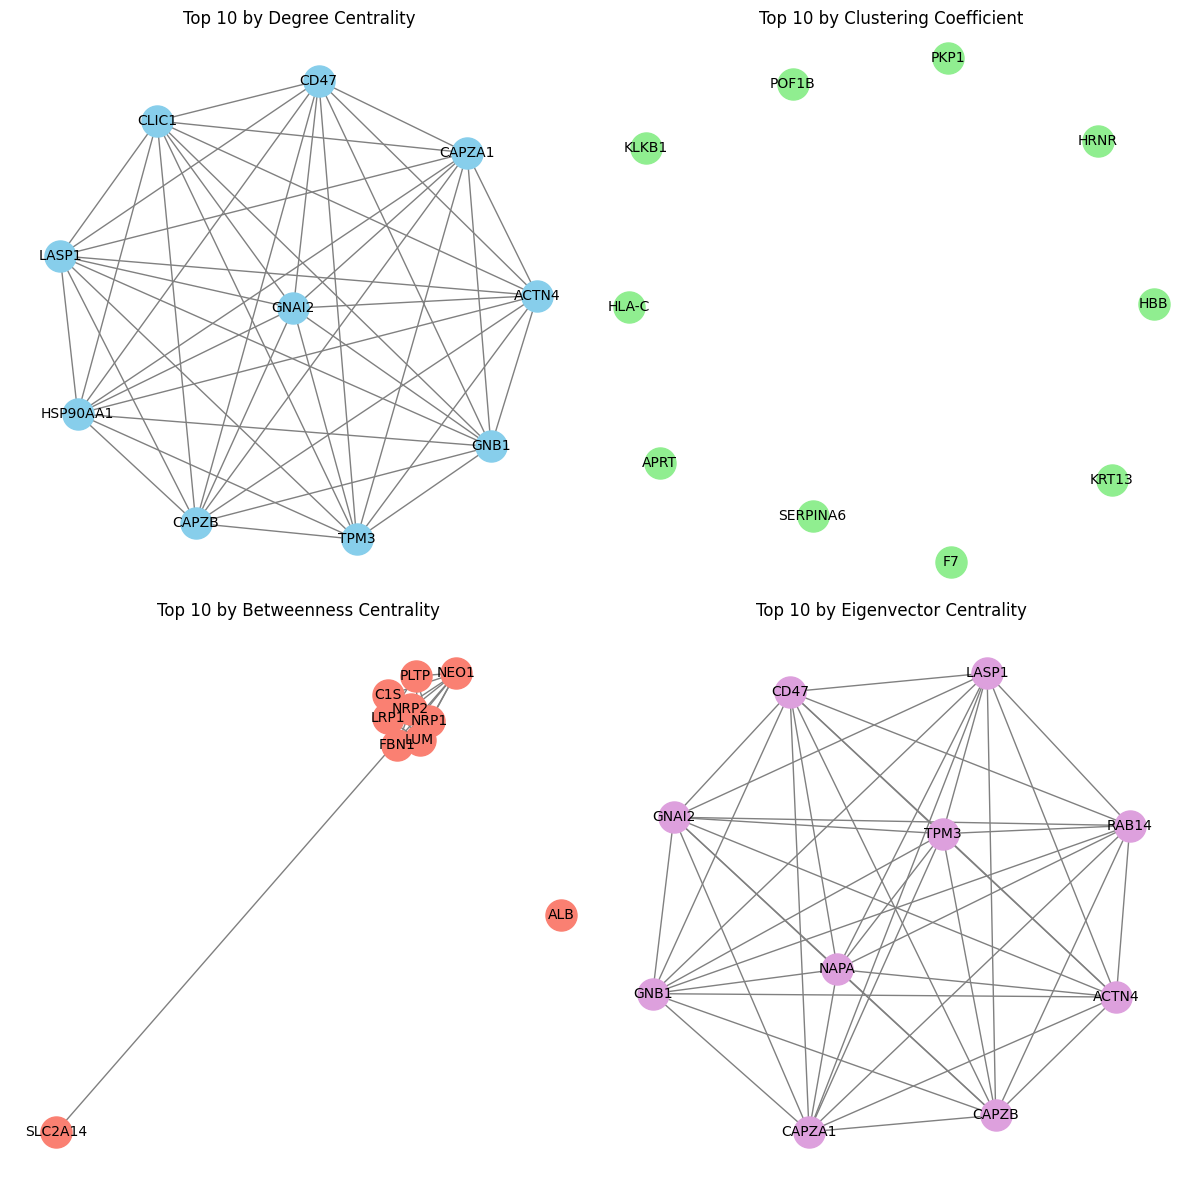

In [23]:
# Identify hub genes for each metric
degree_centrality = nx.degree_centrality(combined_network)
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
clustering = nx.clustering(combined_network)
sorted_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True)
betweenness = nx.betweenness_centrality(combined_network)
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
eigenvector = nx.eigenvector_centrality(combined_network)
sorted_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)

# Select top 10 genes for each metric
top_degree_centrality_genes = [gene for gene, _ in sorted_centrality[:10]]
top_clustering_genes = [gene for gene, _ in sorted_clustering[:10]]
top_betweenness_genes = [gene for gene, _ in sorted_betweenness[:10]]
top_eigenvector_genes = [gene for gene, _ in sorted_eigenvector[:10]]

# Create subgraphs
subgraph_degree_centrality = combined_network.subgraph(top_degree_centrality_genes)
subgraph_clustering = combined_network.subgraph(top_clustering_genes)
subgraph_betweenness = combined_network.subgraph(top_betweenness_genes)
subgraph_eigenvector = combined_network.subgraph(top_eigenvector_genes)

# Plot subgraphs
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Degree Centrality Subgraph
nx.draw(subgraph_degree_centrality,ax=axes[0, 0],with_labels=True,node_size=500,node_color="skyblue",font_size=10,edge_color="gray",)
axes[0, 0].set_title("Top 10 by Degree Centrality")

# Clustering Coefficient Subgraph
nx.draw(subgraph_clustering,ax=axes[0, 1],with_labels=True,node_size=500,node_color="lightgreen",font_size=10,edge_color="gray",)
axes[0, 1].set_title("Top 10 by Clustering Coefficient")

# Betweenness Centrality Subgraph
nx.draw(subgraph_betweenness,ax=axes[1, 0],with_labels=True,node_size=500,node_color="salmon",font_size=10,edge_color="gray",)
axes[1, 0].set_title("Top 10 by Betweenness Centrality")

# Eigenvector Centrality Subgraph
nx.draw(subgraph_eigenvector, ax=axes[1, 1],with_labels=True,node_size=500,node_color="plum",font_size=10,edge_color="gray",)
axes[1, 1].set_title("Top 10 by Eigenvector Centrality")

plt.tight_layout()
plt.show()

##### Degree centrality
The amount of connections within the network
##### Clustering coefficient
Based on highest correlation, indicating clustering
##### Betweenness centrality
These genes connect different hubs with eachother
##### Eigenvector centrality
Connected with other well connected genes

## SEPERATE

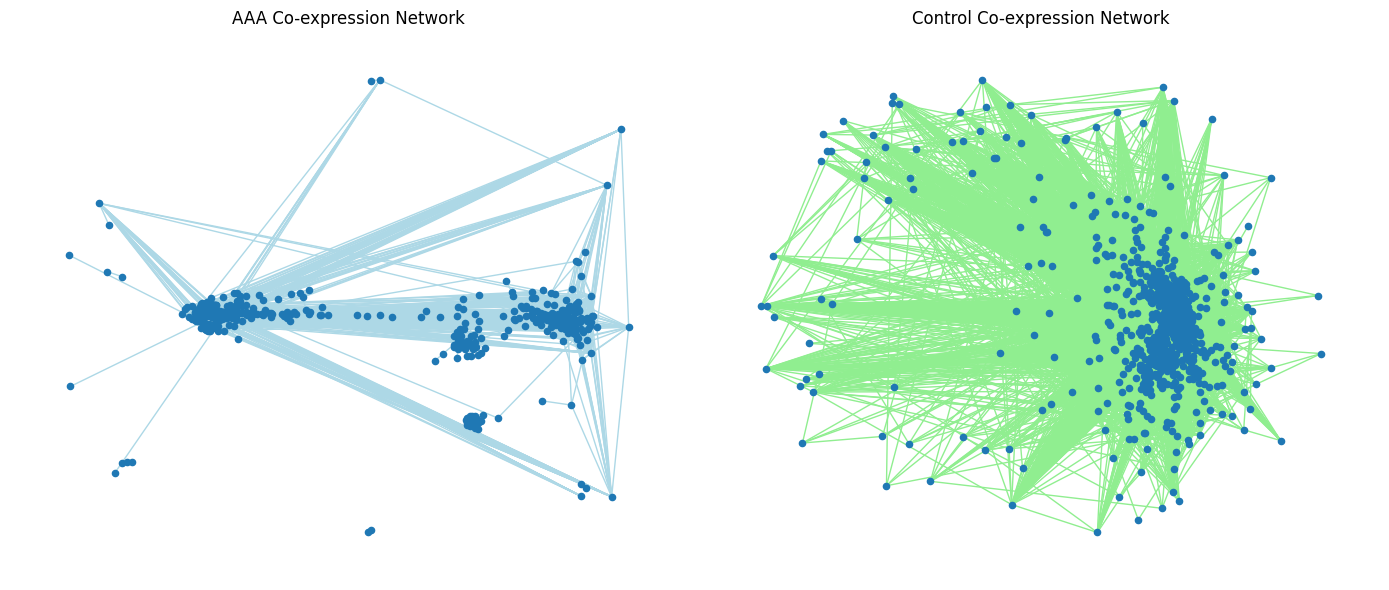

Top 10 hub genes in AAA network:
[('GNAI2', 466), ('CLIC1', 461), ('STOM', 456), ('CAPZA1', 455), ('CAPZB', 455), ('MMRN1', 455), ('NAPA', 454), ('GP9', 454), ('EIF4A1', 454), ('PARVB', 453)]

Top 10 hub genes in control network:
[('ITGAV', 486), ('PDIA6', 449), ('ACTN4', 449), ('CAPZB', 438), ('SKAP2', 438), ('TUBB4B', 437), ('SUSD1', 437), ('MAPRE1', 435), ('ARPC5', 434), ('CNN2', 433)]


In [24]:
d = DAP(df, "Sample_index", "SimplePathology", proteins)
d.missing_filtering(25, percentage=True)
tdf = d.get_data()
aaa = tdf[tdf["SimplePathology"]=="AAA"][d.get_proteins()+["Sample_index"]]
control = tdf[tdf["SimplePathology"]=="Control"][d.get_proteins()+["Sample_index"]]

# Set Gene_Name as the index for easier gene identification
aaa = aaa.set_index(aaa["Sample_index"])
control = control.set_index(control["Sample_index"])

aaa = aaa.drop(["Sample_index"], axis=1)
control = control.drop(["Sample_index"], axis=1)

# Calculate the correlation matrices separately 
aaa_corr_matrix = calculate_correlation_matrix(aaa)
control_corr_matrix = calculate_correlation_matrix(control)

# Create networks 
aaa_network = create_network(aaa_corr_matrix)
control_network = create_network(control_corr_matrix)

# Plot side-by-side subgraphs
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
pos_five_x_fad = nx.spring_layout(aaa_network, seed=42)
nx.draw(aaa_network, pos_five_x_fad, with_labels=False, node_size=20, edge_color="lightblue")
plt.title("AAA Co-expression Network")
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
pos_wt = nx.spring_layout(control_network, seed=42)
nx.draw(control_network, pos_wt, with_labels=False, node_size=20, edge_color="lightgreen")
plt.title("Control Co-expression Network")
plt.tight_layout()
plt.show()

# Identify and print top 10 hub genes for both networks
aaa_degrees = dict(aaa_network.degree())
sorted_aaa_genes = sorted(aaa_degrees.items(), key=lambda x: x[1], reverse=True)
print("Top 10 hub genes in AAA network:")
print(sorted_aaa_genes[:10])
control_degrees = dict(control_network.degree())
sorted_control_genes = sorted(control_degrees.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 hub genes in control network:")
print(sorted_control_genes[:10])

In [25]:
density_aaa = nx.density(aaa_network)
density_control = nx.density(control_network)
print(f"Density of AAA network: {density_aaa}")
print(f"Density of control network: {density_control}")

Density of AAA network: 0.2684403201089733
Density of control network: 0.1684738712937348


In [26]:
avg_degree_aaa = sum(dict(aaa_network.degree()).values()) / len(aaa_network.nodes)
avg_degree_control = sum(dict(control_network.degree()).values()) / len(control_network.nodes)
print(f"Average degree in AAA network: {avg_degree_aaa}")
print(f"Average degree in control network: {avg_degree_control}")

Average degree in AAA network: 225.22142857142856
Average degree in control network: 170.49555774925963


In [27]:
hub_genes_aaa = set([gene for gene, degree in sorted_aaa_genes[:10]])
hub_genes_control = set([gene for gene, degree in sorted_control_genes[:10]])

# Find common and unique hub genes
common_hub_genes = hub_genes_aaa.intersection(hub_genes_control)
unique_aaa_hub_genes = hub_genes_aaa - hub_genes_control
unique_control_hub_genes = hub_genes_control - hub_genes_aaa
print(f"Common hub genes: {common_hub_genes}")
print(f"Unique AAA hub genes: {unique_aaa_hub_genes}")
print(f"Unique control hub genes: {unique_control_hub_genes}")

Common hub genes: {'CAPZB'}
Unique AAA hub genes: {'GNAI2', 'MMRN1', 'EIF4A1', 'CLIC1', 'NAPA', 'PARVB', 'STOM', 'GP9', 'CAPZA1'}
Unique control hub genes: {'MAPRE1', 'SKAP2', 'TUBB4B', 'PDIA6', 'CNN2', 'SUSD1', 'ARPC5', 'ITGAV', 'ACTN4'}


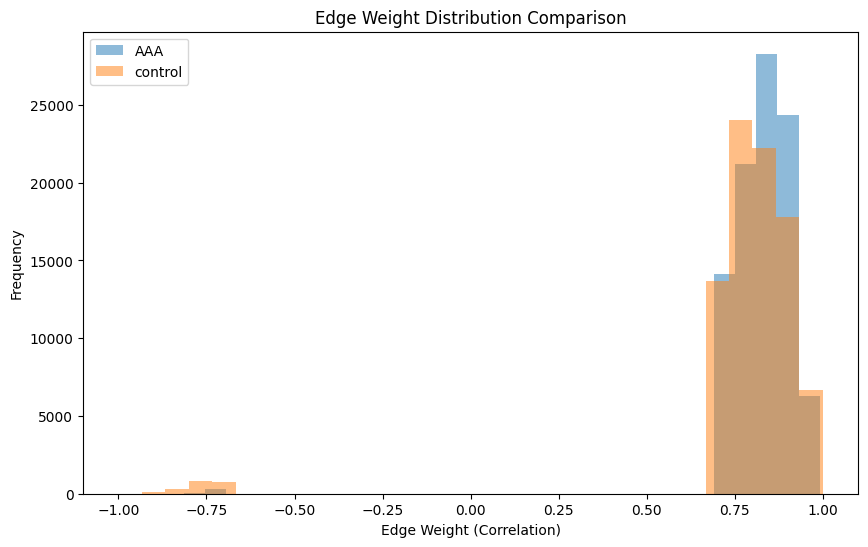

In [28]:
edge_weights_aaa = [data['weight'] for _, _, data in aaa_network.edges(data=True)]
edge_weights_control = [data['weight'] for _, _, data in control_network.edges(data=True)]
plt.figure(figsize=(10, 6))
plt.hist(edge_weights_aaa, bins=30, alpha=0.5, label='AAA')
plt.hist(edge_weights_control, bins=30, alpha=0.5, label='control')
plt.legend()
plt.title('Edge Weight Distribution Comparison')
plt.xlabel('Edge Weight (Correlation)')
plt.ylabel('Frequency')
plt.show()

## Total intensity normalization

In [29]:
d = DAP(df, "Sample_index", "SimplePathology", proteins)
d.missing_filtering(25, percentage=True)
d.total_intensity_normalization()
tdf = d.get_data()[d.get_proteins()]

In [30]:
combined_corr_matrix = calculate_correlation_matrix(tdf)
combined_corr_matrix.head()

EEF1G     PSMD5       RAN    LGALS1    CAPZA1    PPP1CB    NAP1L4  \
EEF1G   1.000000  0.636948  0.047531 -0.216405  0.884265  0.678322  0.872575   
PSMD5   0.636948  1.000000  0.078301 -0.199875  0.519800  0.567547  0.753136   
RAN     0.047531  0.078301  1.000000  0.237340 -0.004285 -0.018725  0.238633   
LGALS1 -0.216405 -0.199875  0.237340  1.000000 -0.097260  0.214827 -0.188235   
CAPZA1  0.884265  0.519800 -0.004285 -0.097260  1.000000  0.799061  0.798113   

          CAPZA2      CAP1     CALM1  ...     ACTN3     HYDIN   B4GALT5  \
EEF1G   0.831854  0.622638  0.823966  ... -0.445431 -0.224639 -0.224654   
PSMD5   0.584484  0.243294  0.558251  ... -0.514539 -0.438243 -0.130275   
RAN    -0.122034 -0.006152  0.340229  ...  0.560293  0.579060  0.533602   
LGALS1 -0.062335  0.146401  0.023785  ...  0.332883  0.358667  0.171232   
CAPZA1  0.955463  0.833167  0.805169  ... -0.499775 -0.259348 -0.311204   

           PRSS3   C1QTNF5      CD63  IGHV4-30-2     IGKJ1     IGLL1  \
EEF1G  -0.316964 -0.800234  0.792254   -0.455205 -0.331531 -0.146325   
PSMD5  -0.462561 -0.554831  0.523855   -0.212587 -0.384457 -0.224470   
RAN     0.622248  0.496610 -0.110376    0.376188  0.405846  0.373929   
LGALS1  0.344581  0.232613 -0.011210    0.209155  0.240516  0.226407   
CAPZA1 -0.292114 -0.860725  0.850164   -0.426461 -0.303288 -0.124114   

        IGKV6D-21  
EEF1G   -0.089910  
PSMD5   -0.123012  
RAN      0.331181  
LGALS1   0.097896  
CAPZA1  -0.016804  

[5 rows x 1017 columns]

In [31]:
# Define threshold for correlation
threshold = 0.75

# Create combined network for all samples and analyze the combined network 
combined_network = create_network(combined_corr_matrix, threshold)
print(f"Combined Network: {combined_network.number_of_nodes()} nodes and {combined_network.number_of_edges()} edges")

Combined Network: 942 nodes and 73544 edges


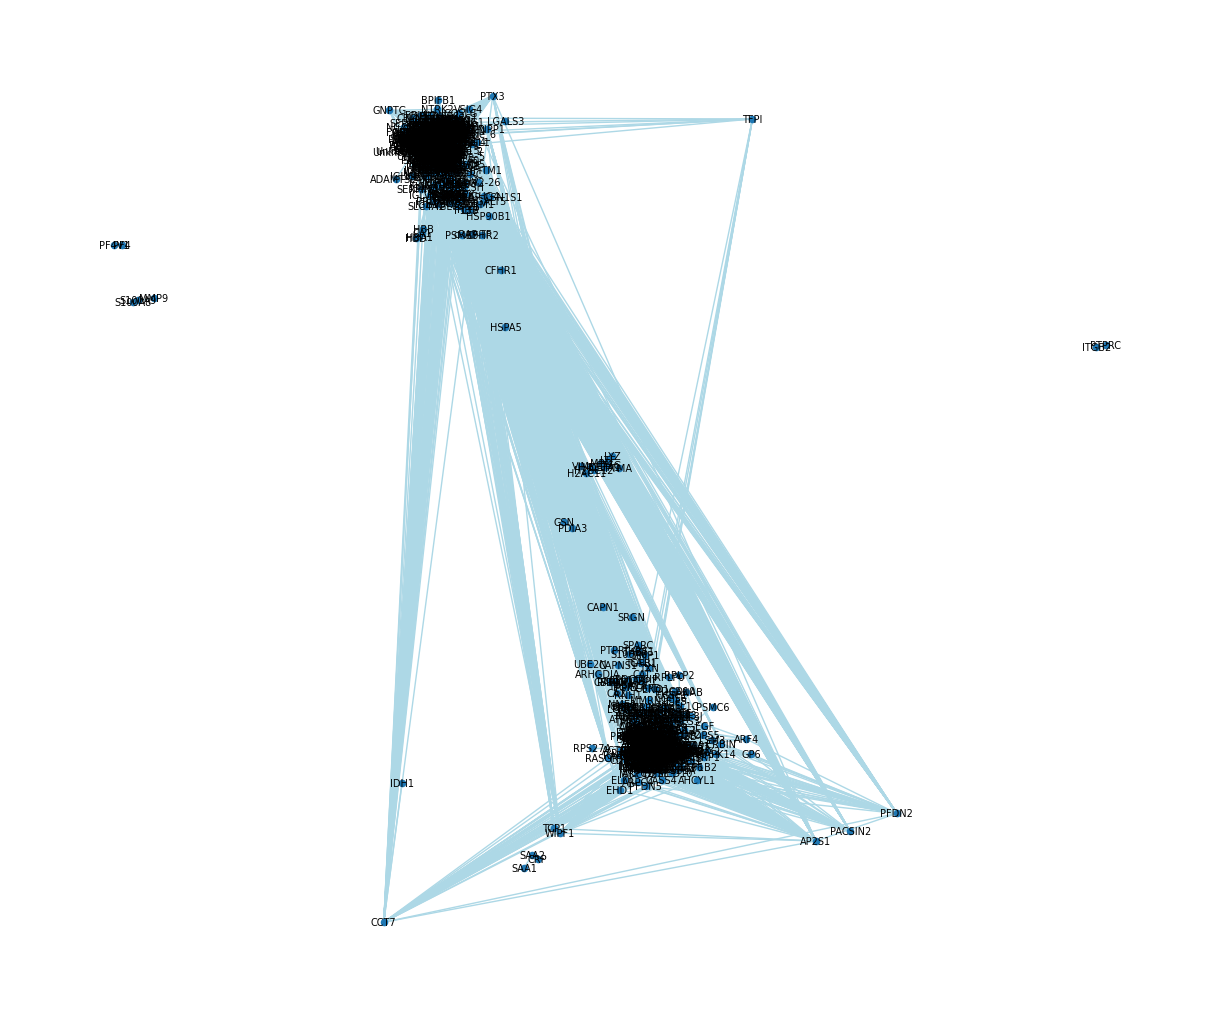

Top 10 hub genes:
[('C1QTNF5', 403), ('VTN', 400), ('ITIH2', 395), ('NRP1', 395), ('TNC', 394), ('NEO1', 394), ('LUM', 393), ('NRP2', 392), ('SERPING1', 390), ('VCAM1', 390)]


In [32]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(combined_network, seed=42)
nx.draw(combined_network, pos, with_labels=False, node_size=20, edge_color="lightblue")
nx.draw_networkx_labels(combined_network, pos, labels={node: node for node in combined_network.nodes}, font_size=7)
plt.show()

# identify hub genes in network
degrees = dict(combined_network.degree())
sorted_genes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
print("Top 10 hub genes:")
print(sorted_genes[:10])

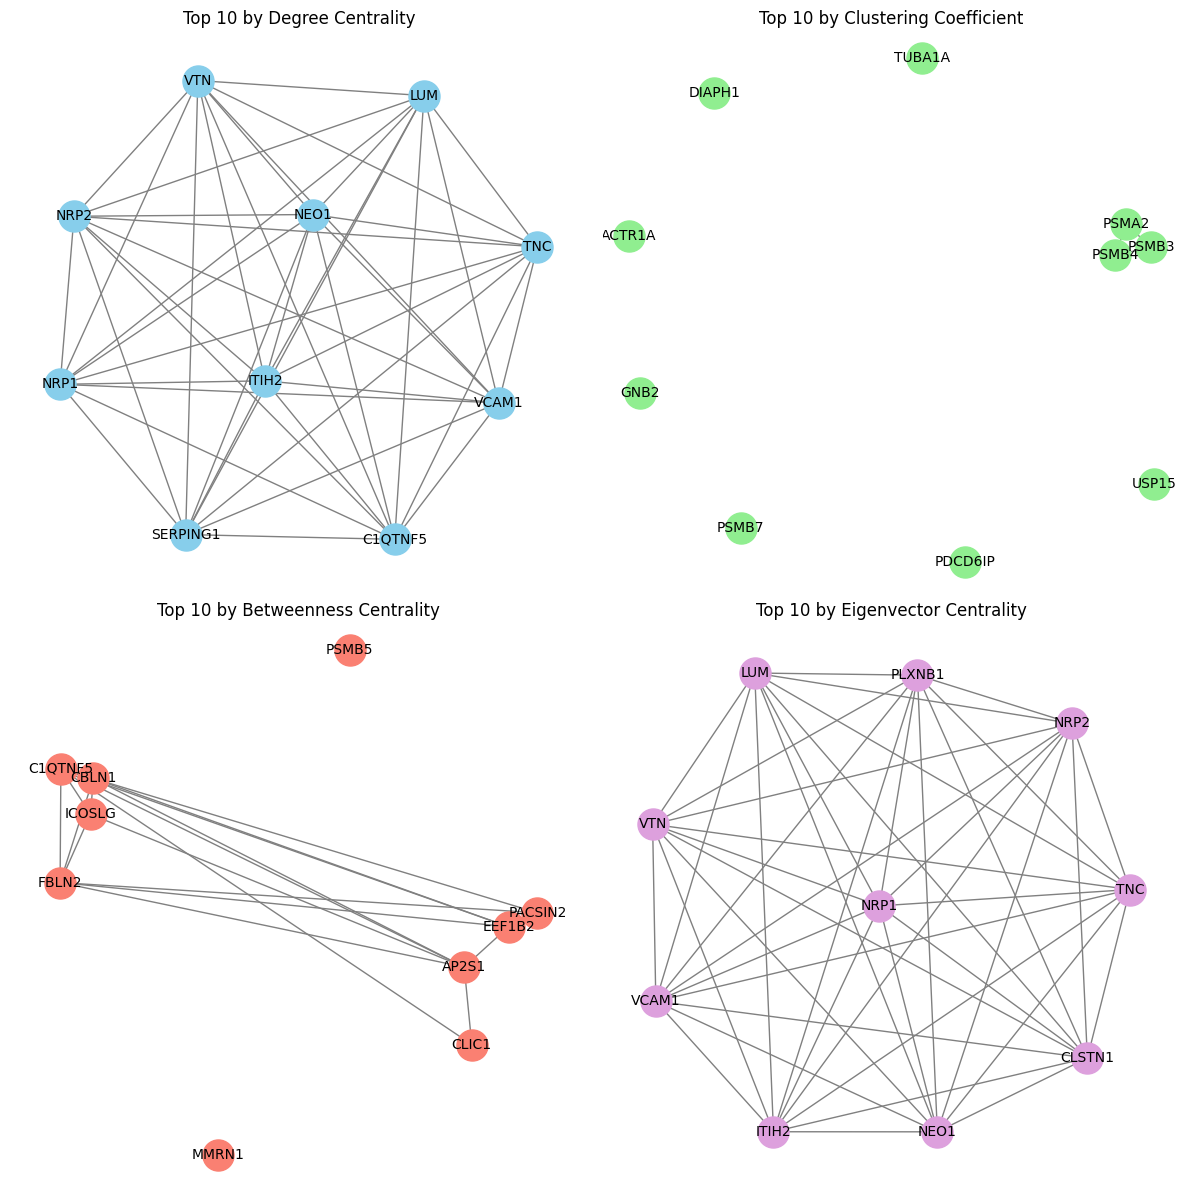

In [33]:
# Identify hub genes for each metric
degree_centrality = nx.degree_centrality(combined_network)
sorted_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
clustering = nx.clustering(combined_network)
sorted_clustering = sorted(clustering.items(), key=lambda x: x[1], reverse=True)
betweenness = nx.betweenness_centrality(combined_network)
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
eigenvector = nx.eigenvector_centrality(combined_network)
sorted_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)

# Select top 10 genes for each metric
top_degree_centrality_genes = [gene for gene, _ in sorted_centrality[:10]]
top_clustering_genes = [gene for gene, _ in sorted_clustering[:10]]
top_betweenness_genes = [gene for gene, _ in sorted_betweenness[:10]]
top_eigenvector_genes = [gene for gene, _ in sorted_eigenvector[:10]]

# Create subgraphs
subgraph_degree_centrality = combined_network.subgraph(top_degree_centrality_genes)
subgraph_clustering = combined_network.subgraph(top_clustering_genes)
subgraph_betweenness = combined_network.subgraph(top_betweenness_genes)
subgraph_eigenvector = combined_network.subgraph(top_eigenvector_genes)

# Plot subgraphs
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Degree Centrality Subgraph
nx.draw(subgraph_degree_centrality,ax=axes[0, 0],with_labels=True,node_size=500,node_color="skyblue",font_size=10,edge_color="gray",)
axes[0, 0].set_title("Top 10 by Degree Centrality")

# Clustering Coefficient Subgraph
nx.draw(subgraph_clustering,ax=axes[0, 1],with_labels=True,node_size=500,node_color="lightgreen",font_size=10,edge_color="gray",)
axes[0, 1].set_title("Top 10 by Clustering Coefficient")

# Betweenness Centrality Subgraph
nx.draw(subgraph_betweenness,ax=axes[1, 0],with_labels=True,node_size=500,node_color="salmon",font_size=10,edge_color="gray",)
axes[1, 0].set_title("Top 10 by Betweenness Centrality")

# Eigenvector Centrality Subgraph
nx.draw(subgraph_eigenvector, ax=axes[1, 1],with_labels=True,node_size=500,node_color="plum",font_size=10,edge_color="gray",)
axes[1, 1].set_title("Top 10 by Eigenvector Centrality")

plt.tight_layout()
plt.show()

#### Seperate

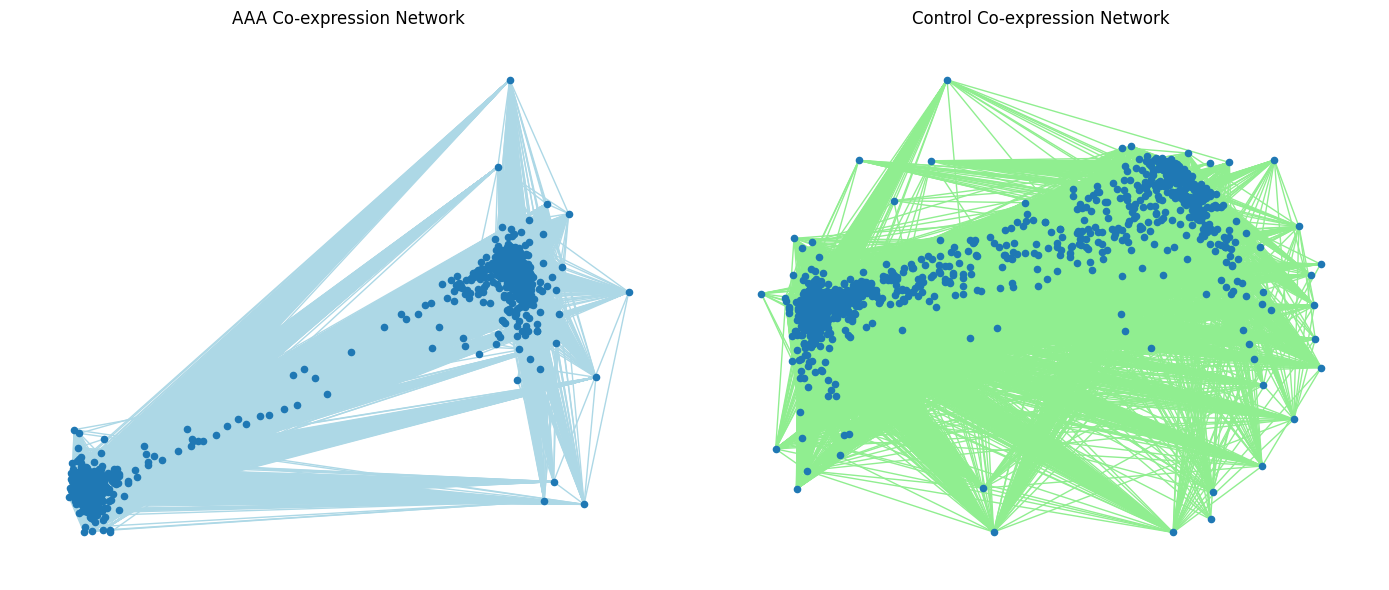

Top 10 hub genes in AAA network:
[('C1QTNF5', 608), ('AP2S1', 571), ('VCAM1', 534), ('NRP2', 534), ('SERPING1', 532), ('LCAT', 530), ('APOA1', 524), ('NEO1', 524), ('ITIH2', 523), ('NRP1', 523)]

Top 10 hub genes in control network:
[('IGHV3-43', 551), ('XP32', 525), ('FAT4', 506), ('AXL', 494), ('PCDHGC3', 480), ('ITIH2', 477), ('TNC', 474), ('F10', 474), ('C1RL', 472), ('DPT', 471)]


In [34]:
d = DAP(df, "Sample_index", "SimplePathology", proteins)
d.missing_filtering(30, percentage=True)
d.total_intensity_normalization()
tdf = d.get_data()
aaa = tdf[tdf["SimplePathology"]=="AAA"][d.get_proteins()+["Sample_index"]]
control = tdf[tdf["SimplePathology"]=="Control"][d.get_proteins()+["Sample_index"]]

# Set Gene_Name as the index for easier gene identification
aaa = aaa.set_index(aaa["Sample_index"])
control = control.set_index(control["Sample_index"])

aaa = aaa.drop(["Sample_index"], axis=1)
control = control.drop(["Sample_index"], axis=1)

# Calculate the correlation matrices separately 
aaa_corr_matrix = calculate_correlation_matrix(aaa)
control_corr_matrix = calculate_correlation_matrix(control)

# Create networks 
aaa_network = create_network(aaa_corr_matrix)
control_network = create_network(control_corr_matrix)

# Plot side-by-side subgraphs
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
pos_five_x_fad = nx.spring_layout(aaa_network, seed=42)
nx.draw(aaa_network, pos_five_x_fad, with_labels=False, node_size=20, edge_color="lightblue")
plt.title("AAA Co-expression Network")
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
pos_wt = nx.spring_layout(control_network, seed=42)
nx.draw(control_network, pos_wt, with_labels=False, node_size=20, edge_color="lightgreen")
plt.title("Control Co-expression Network")
plt.tight_layout()
plt.show()

# Identify and print top 10 hub genes for both networks
aaa_degrees = dict(aaa_network.degree())
sorted_aaa_genes = sorted(aaa_degrees.items(), key=lambda x: x[1], reverse=True)
print("Top 10 hub genes in AAA network:")
print(sorted_aaa_genes[:10])
control_degrees = dict(control_network.degree())
sorted_control_genes = sorted(control_degrees.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 hub genes in control network:")
print(sorted_control_genes[:10])

In [35]:
density_aaa = nx.density(aaa_network)
density_control = nx.density(control_network)
print(f"Density of AAA network: {density_aaa}")
print(f"Density of control network: {density_control}")

Density of AAA network: 0.23452948978152874
Density of control network: 0.2161352460925284


In [36]:
avg_degree_aaa = sum(dict(aaa_network.degree()).values()) / len(aaa_network.nodes)
avg_degree_control = sum(dict(control_network.degree()).values()) / len(control_network.nodes)
print(f"Average degree in AAA network: {avg_degree_aaa}")
print(f"Average degree in control network: {avg_degree_control}")

Average degree in AAA network: 248.1322001888574
Average degree in control network: 236.88422971741113


In [37]:
hub_genes_aaa = set([gene for gene, degree in sorted_aaa_genes[:10]])
hub_genes_control = set([gene for gene, degree in sorted_control_genes[:10]])

# Find common and unique hub genes
common_hub_genes = hub_genes_aaa.intersection(hub_genes_control)
unique_aaa_hub_genes = hub_genes_aaa - hub_genes_control
unique_control_hub_genes = hub_genes_control - hub_genes_aaa
print(f"Common hub genes: {common_hub_genes}")
print(f"Unique AAA hub genes: {unique_aaa_hub_genes}")
print(f"Unique control hub genes: {unique_control_hub_genes}")

Common hub genes: {'ITIH2'}
Unique AAA hub genes: {'LCAT', 'NEO1', 'VCAM1', 'C1QTNF5', 'APOA1', 'AP2S1', 'NRP1', 'NRP2', 'SERPING1'}
Unique control hub genes: {'IGHV3-43', 'C1RL', 'PCDHGC3', 'FAT4', 'TNC', 'AXL', 'F10', 'DPT', 'XP32'}


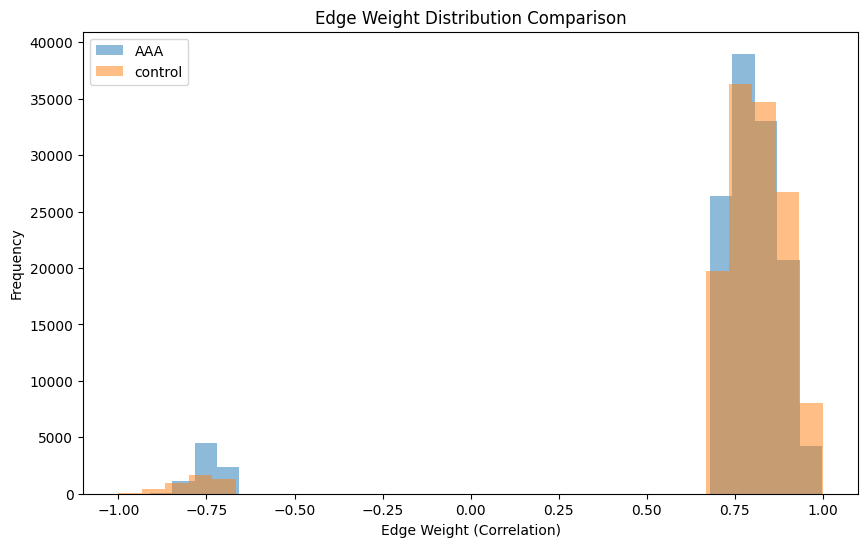

In [38]:
edge_weights_aaa = [data['weight'] for _, _, data in aaa_network.edges(data=True)]
edge_weights_control = [data['weight'] for _, _, data in control_network.edges(data=True)]
plt.figure(figsize=(10, 6))
plt.hist(edge_weights_aaa, bins=30, alpha=0.5, label='AAA')
plt.hist(edge_weights_control, bins=30, alpha=0.5, label='control')
plt.legend()
plt.title('Edge Weight Distribution Comparison')
plt.xlabel('Edge Weight (Correlation)')
plt.ylabel('Frequency')
plt.show()